In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

!pip install torchinfo
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install madgrad
!pip install gdown

In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd /content

Cloning into 'apex'...
remote: Enumerating objects: 9614, done.
remote: Counting objects: 100% (685/685), done.
remote: Compressing objects: 100% (343/343), done.
remote: Total 9614 (delta 417), reused 516 (delta 323), pack-reused 8929
Receiving objects: 100% (9614/9614), 14.81 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (6530/6530), done.
/content/apex
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/loc

In [ ]:
!pip uninstall -y opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52


Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
     |████████████████████████████████| 38.2 MB 1.2 MB/s 


# **Download Dataset that contains submission models**

In [ ]:
!gdown https://drive.google.com/uc?id=12XDPAunVLuvZcBKBHUn2HWOAaTYOvWLG
!unzip /content/turtle-recall-submission.zip -d /content/turtle-recall-submission/

Downloading...
From: https://drive.google.com/uc?id=12XDPAunVLuvZcBKBHUn2HWOAaTYOvWLG
To: /content/turtle-recall-submission.zip
100% 5.81G/5.81G [00:33<00:00, 175MB/s]
Archive:  /content/turtle-recall-submission.zip
  inflating: /content/turtle-recall-submission/.ipynb_checkpoints/dataset-metadata-checkpoint.json  
  inflating: /content/turtle-recall-submission/.ipynb_checkpoints/readme-checkpoint.txt  
  inflating: /content/turtle-recall-submission/ConvNeXtBase(Extra)(DOLG)(GEM)/.ipynb_checkpoints/train-checkpoint.log  
  inflating: /content/turtle-recall-submission/ConvNeXtBase(Extra)(DOLG)(GEM)/config.pickle  
  inflating: /content/turtle-recall-submission/ConvNeXtBase(Extra)(DOLG)(GEM)/model_0.pth  
  inflating: /content/turtle-recall-submission/ConvNeXtBase(Extra)(DOLG)(GEM)/model_1.pth  
  inflating: /content/turtle-recall-submission/ConvNeXtBase(Extra)(DOLG)(GEM)/model_2.pth  
  inflating: /content/turtle-recall-submission/ConvNeXtBase(Extra)(DOLG)(GEM)/model_3.pth  
  inflating

In [ ]:
import timm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from tqdm import tqdm
import glob

import time
import math

from albumentations import *
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

import torch
from torch.autograd import Variable
import torch.nn.functional as F
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse
    
import yaml
from torch.nn.parameter import Parameter



import sys



import torch.nn as nn

tqdm.pandas()

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR, StepLR


import requests
import io
import urllib.parse

import copy,shutil
from numba import jit
import os.path as osp
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import apex

from apex import amp
from sklearn.neighbors import NearestNeighbors

import pickle
from PIL import Image
import math
import copy

/usr/local/lib/python3.7/dist-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [ ]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = '/content/turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [ ]:
BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))


# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
extra = read_csv_from_web('extra_images.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

# **The Next Cell is used to recreate the train_folds.csv file**

In [ ]:
IMAGE_DIR = '/content/turtle_recall/images'

NFOLDS = 5

common_idxs = list(set(train.turtle_id.unique()).intersection(set(extra.turtle_id.unique())))

common_df = extra.loc[extra.turtle_id.isin(common_idxs)].copy()
extra = extra.loc[~extra.turtle_id.isin(common_idxs)].copy()
train = train.append(common_df)

train.reset_index(inplace=True, drop=True)
extra.reset_index(inplace=True, drop=True)

extra['extra'] = True
train['extra'] = False


skf  = StratifiedKFold(n_splits = NFOLDS, shuffle=True, random_state=1) # num_folds=3 as there are total 3 videos
for fold, (train_idx, val_idx) in enumerate(skf.split(train, train.turtle_id.tolist())):
    train.loc[val_idx, 'fold'] = fold
    
gkf  = GroupKFold(n_splits = NFOLDS*16) # num_folds=3 as there are total 3 videos
for fold, (train_idx, val_idx) in enumerate(gkf.split(extra, groups=extra.turtle_id.tolist())):
    extra.loc[val_idx, 'fold'] = fold
    


extra.loc[extra.fold >= 5, 'fold'] == -1
train_df = train.append(extra).copy()
train_df.reset_index(inplace=True, drop=True)
train_df['uidx'] = train_df.index + 1
train_df['path'] = train_df.apply(lambda row: osp.join(IMAGE_DIR, row.image_id+'.JPG'), axis=1)
train_df.rename(columns={'turtle_id': 'individual_id'}, inplace=True)
train_df['counts'] = train_df.groupby(['individual_id'])['individual_id'].transform('count')

mapper = {k:v for v, k in enumerate(np.unique(list(np.unique(train.turtle_id.values)) + list(np.unique(extra.turtle_id.values))))}
train_df['target'] = train_df.apply(lambda row:mapper[row.individual_id], axis=1)

train_df.loc[train_df.extra == True, 'fold'] = -1


In [ ]:
len(train_df.individual_id.unique())

2265

In [ ]:
train_df.head()

,image_id,image_location,individual_id,extra,fold,uidx,path,counts,target
0,ID_2RK4WLN8,top,t_id_VP2NW7aV,False,4.0,1,/content/turtle_recall/images/ID_2RK4WLN8.JPG,69,1147
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC,False,2.0,2,/content/turtle_recall/images/ID_VVW0QXLX.JPG,23,1918
2,ID_RVATH2HZ,right,t_id_3b65X5Lw,False,3.0,3,/content/turtle_recall/images/ID_RVATH2HZ.JPG,26,145
3,ID_2GB90GPS,left,t_id_YjXYTCGC,False,1.0,4,/content/turtle_recall/images/ID_2GB90GPS.JPG,71,1272
4,ID_LM6S0B1M,top,t_id_d6aYXtor,False,0.0,5,/content/turtle_recall/images/ID_LM6S0B1M.JPG,11,1440


The mean number of training images per turtle is 5.65, and the median is 3.


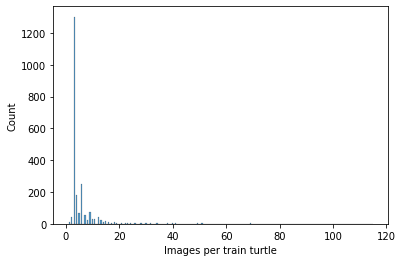

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_images_per_turtle = pd.value_counts(train_df['individual_id'])
print('The mean number of training images per turtle is '
      f'{round(np.mean(train_images_per_turtle), 2)}, '
      f'and the median is {int(np.median(train_images_per_turtle))}.')
sns.histplot(train_images_per_turtle)
plt.xlabel('Images per train turtle')
plt.show()

In [ ]:
class CFG1:
    apex                           = True
    print_freq                     = 100
    num_workers                    = 4
    model_name                     = 'ConvNeXtLarge(DOLG)(GEM)'
    size                           = 640
    scheduler                      = 'OneCycleLR' 
    epochs                         = 16
    max_lr                         = 0.3e-3
    final_div_factor                = 100
    div_factor                     = 25
    pct                            = 0.3
    batch_size                     = 16
    weight_decay                   = 1e-6
    gradient_accumulation_steps    = 1
    max_grad_norm                  = 1000
    seed                           = 1
    nfolds                         = 5

    KNN                            = 200


    optimizer                      = 'Adam'


    loss                           = 'adaptive_arcface'
    arcface_m_x                    = 0.5
    arcface_m_y                    = 0.2
    arcface_s                      = 40
    arcface_m                      = 0.3
    dilations                      = [6,12,18]
    stride                         = (2,2)
    in_channels                    = 3
    backbone                       = 'convnext_large_384_in22ft1k'
    pretrained                     = True
    neck                           = "option-D"
    embedding_size                 = 512
    pool                           = "gem"
    gem_p_trainable                = True
    headless                       = False
    dropout                        = 0.0

    
    
    extra_train                    = False
    
    n_classes                      = 100





class CFG2:
    apex                           = True
    print_freq                     = 100
    num_workers                    = 4
    model_name                     = 'ConvNeXtBase(Extra)(DOLG)(GEM)'
    size                           = 640
    scheduler                      = 'OneCycleLR' 
    epochs                         = 20
    max_lr                         = 0.3e-3
    final_div_factor                = 100
    div_factor                     = 25
    pct                            = 0.3
    batch_size                     = 16
    weight_decay                   = 1e-5
    gradient_accumulation_steps    = 1
    max_grad_norm                  = 1000
    seed                           = 1
    nfolds                         = 5

    KNN                            = 200


    optimizer                      = 'Adam'


    loss                           = 'adaptive_arcface'
    arcface_m_x                    = 0.5
    arcface_m_y                    = 0.1
    arcface_s                      = 45
    arcface_m                      = 0.3
    dilations                      = [6,12,18]
    stride                         = (2,2)
    in_channels                    = 3
    backbone                       = 'convnext_base_384_in22ft1k'
    pretrained                     = True
    neck                           = "option-D"
    embedding_size                 = 512
    pool                           = "gem"
    gem_p_trainable                = True
    headless                       = False
    dropout                        = 0.0

    
    
    
    
    extra_train                    = True
    
    n_classes                      = 2265
    


        

    
    
    
    
    
      

# **Set Configuration**

In [ ]:
# toggle between experiments, final submission is ensemble of (5 folds * 2 models) total 10 models
CFG = copy.deepcopy(CFG2)#CFG2

In [ ]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(CFG.seed)

In [ ]:
class TurtlesDataset(Dataset):
    def __init__(self, df, train=True, transform=None):
        super().__init__()


        self.train = train
        self.df = df
        self.uidxs = df['uidx'].unique()
        self.transform  = transform


        tmp = np.sqrt(1 / np.sqrt(train_df['target'].value_counts().sort_index().values))
        self.margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * CFG.arcface_m_x + CFG.arcface_m_y


    def __len__(self):
        return len(self.uidxs)

    def __getitem__(self, idx):
        uidx = self.uidxs[idx]
        row = self.df.loc[self.df['uidx'] == uidx]


        label = row['target'].values[0]



        img = cv2.imread(row['path'].values[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        
        isExtra = row['extra'].values[0]
        
        data = {}
        data['image'] = img
        data['target'] = torch.tensor(label, dtype=torch.long)
        data['individual_id'] = row['individual_id'].values[0] if not isExtra else 'new_individual'
        data['uidx'] = uidx

        return data

def get_aug(p=1.0):
    return Compose([
      
                    

        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),

        ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1, always_apply=False, p=0.5),
        
        ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=10, border_mode=0, value=(114,114,114) , p=0.75),
        
        
        OneOf([
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=10, border_mode=0, value=(114,114,114) , p=1.0),
            Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.2), translate_px=None, rotate=(-45, 45), shear=(-45, 45), interpolation=1, mask_interpolation=0, cval=(114,114,114), cval_mask=0, mode=0, fit_output=False, always_apply=False, p=1.0),
            Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=(114,114,114), mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=1.0),
         ], p=0.75),
            
        OneOf([
              MotionBlur(p=1.0),
              MedianBlur(blur_limit=5, p=1.0),
              GaussianBlur(blur_limit=3, p=1.0),
              AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), always_apply=False, p=1.0),
          ], p=0.1),

        # CustomResize(768, color=(114, 114, 114), auto=False, scaleup=False, p=1.0),
        # RandomCrop(CFG.size, CFG.size, p=1.0),

        Resize(CFG.size, CFG.size),
        Cutout(max_h_size=int(CFG.size * 0.15), max_w_size=int(CFG.size * 0.15), num_holes=8, fill_value=114, p=0.1),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], p=p)


def get_aug_val(p=1.0):
    return Compose([
        Resize(CFG.size, CFG.size),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], p=p)

In [ ]:
if not CFG.extra_train:
    train_df = train_df.loc[train_df.extra == False].copy()
    mapper = {k:v for v, k in enumerate(np.unique(list(np.unique(train_df.individual_id.values))))}
    train_df['target'] = train_df.apply(lambda row:mapper[row.individual_id], axis=1)
    


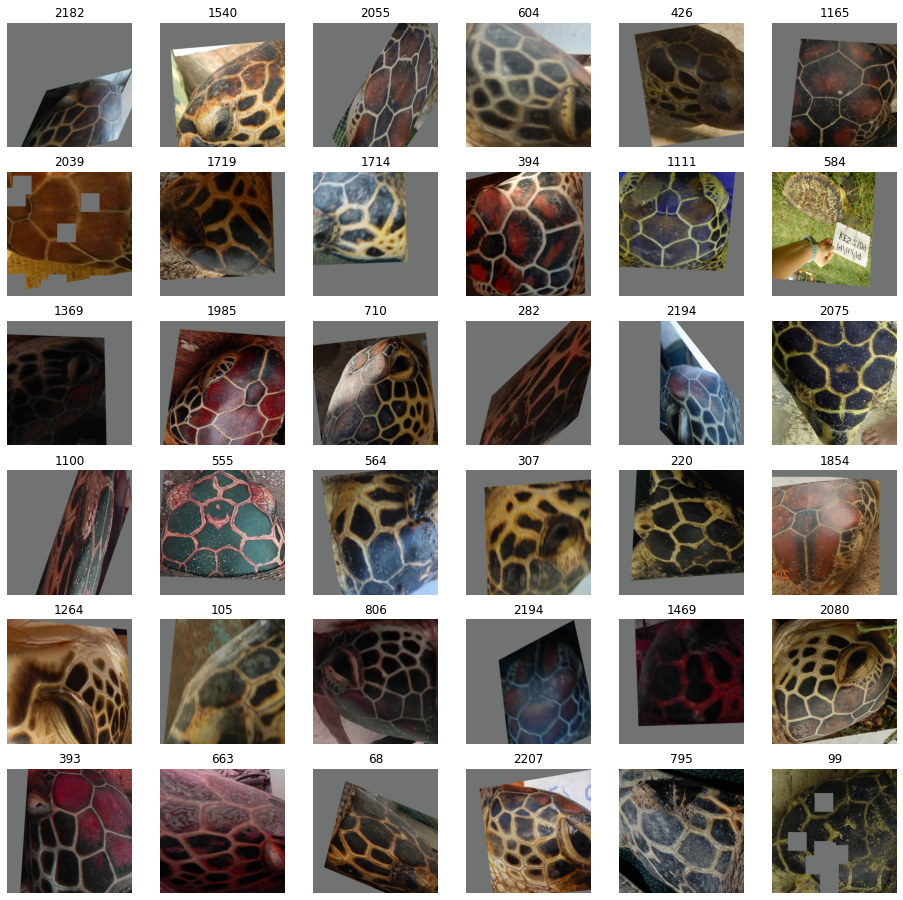

In [ ]:
#example of train images with masks
std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])

ds = TurtlesDataset(train_df, train=True, transform = get_aug())
dl = DataLoader(ds, 
                  batch_size=36, 
                  shuffle=True, 
                  num_workers=0, 
                  # worker_init_fn=worker_init_fn,
                  pin_memory=True, drop_last=False)

batch = next(iter(dl))

imgs, classes = batch['image'], batch['target']


plt.figure(figsize=(16,16))

for i,(img, cls) in enumerate(zip(imgs, classes)):
    
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(6,6,i+1)
    plt.imshow(img,)
    plt.title(f'{cls.data:.0f}')

    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
del ds,dl,imgs

In [ ]:
class Swish(torch.autograd.Function):

    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)



class DenseCrossEntropy(nn.Module):
    def forward(self, x, target):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        return loss.mean()


class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=3):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, features):
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine   


class ArcFaceLossAdaptiveMargin(nn.modules.Module):
    def __init__(self, margins, n_classes, s=30.0):
        super().__init__()
        self.crit = DenseCrossEntropy()
        self.s = s
        self.margins = margins
        self.out_dim =n_classes
            
    def forward(self, logits, labels):
        ms = []
        ms = self.margins[labels.cpu().numpy()]
        cos_m = torch.from_numpy(np.cos(ms)).float().cuda()
        sin_m = torch.from_numpy(np.sin(ms)).float().cuda()
        th = torch.from_numpy(np.cos(math.pi - ms)).float().cuda()
        mm = torch.from_numpy(np.sin(math.pi - ms) * ms).float().cuda()
        labels = F.one_hot(labels, self.out_dim).float()
        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * cos_m.view(-1,1) - sine * sin_m.view(-1,1)
        phi = torch.where(cosine > th.view(-1,1), phi, cosine - mm.view(-1,1))
        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss = self.crit(output, labels)
        return loss     



class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        # stdv = 1. / math.sqrt(self.weight.size(1))
        # self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine


class ArcFaceLoss(nn.modules.Module):
    def __init__(self, s=45.0, m=0.1, crit="bce", weight=None, reduction="mean",class_weights_norm=None ):
        super().__init__()

        self.weight = weight
        self.reduction = reduction
        self.class_weights_norm = class_weights_norm
        
        self.crit = nn.CrossEntropyLoss(reduction="none")   
        
        if s is None:
            self.s = torch.nn.Parameter(torch.tensor([45.], requires_grad=True, device='cuda'))
        else:
            self.s = s

        
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, logits, labels):

        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        labels2 = torch.zeros_like(cosine)
        labels2.scatter_(1, labels.view(-1, 1).long(), 1)
        output = (labels2 * phi) + ((1.0 - labels2) * cosine)

        s = self.s

        output = output * s
        loss = self.crit(output, labels)

        if self.weight is not None:
            w = self.weight[labels].to(logits.device)

            loss = loss * w
            if self.class_weights_norm == "batch":
                loss = loss.sum() / w.sum()
            if self.class_weights_norm == "global":
                loss = loss.mean()
            else:
                loss = loss.mean()
            
            return loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss    

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=False):
        super(GeM,self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        ret = gem(x, p=self.p, eps=self.eps)   
        return ret
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

    

class MultiAtrousModule(nn.Module):
    def __init__(self, in_chans, out_chans, dilations):
        super(MultiAtrousModule, self).__init__()
        
        self.d0 = nn.Conv2d(in_chans, 512, kernel_size=3, dilation=dilations[0],padding='same')
        self.d1 = nn.Conv2d(in_chans, 512, kernel_size=3, dilation=dilations[1],padding='same')
        self.d2 = nn.Conv2d(in_chans, 512, kernel_size=3, dilation=dilations[2],padding='same')
        self.conv1 = nn.Conv2d(512 * 3, out_chans, kernel_size=1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        x0 = self.d0(x)
        x1 = self.d1(x)
        x2 = self.d2(x)
        x = torch.cat([x0,x1,x2],dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        return x

class SpatialAttention2d(nn.Module):
    def __init__(self, in_c):
        super(SpatialAttention2d, self).__init__()
        self.conv1 = nn.Conv2d(in_c, 1024, 1, 1)
        self.bn = nn.BatchNorm2d(1024)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(1024, 1, 1, 1)
        self.softplus = nn.Softplus(beta=1, threshold=20) # use default setting.

    def forward(self, x):
        '''
        x : spatial feature map. (b x c x w x h)
        att : softplus attention score 
        '''
        x = self.conv1(x)
        x = self.bn(x)
        
        feature_map_norm = F.normalize(x, p=2, dim=1)
         
        x = self.act1(x)
        x = self.conv2(x)
        att_score = self.softplus(x)
        att = att_score.expand_as(feature_map_norm)
        
        x = att * feature_map_norm
        return x, att_score   

class OrthogonalFusion(nn.Module):
    def __init__(self):
        super(OrthogonalFusion, self).__init__()

    def forward(self, fl, fg):

        bs, c, w, h = fl.shape
        
        fl_dot_fg = torch.bmm(fg[:,None,:],fl.reshape(bs,c,-1))
        fl_dot_fg = fl_dot_fg.reshape(bs,1,w,h)
        fg_norm = torch.norm(fg, dim=1)
        
        fl_proj = (fl_dot_fg / fg_norm[:,None,None,None]) * fg[:,:,None,None]
        fl_orth = fl - fl_proj
        
        f_fused = torch.cat([fl_orth,fg[:,:,None,None].repeat(1,1,w,h)],dim=1)
        return f_fused  


class Net(nn.Module):
    def __init__(self, CFG, dataset):
        super(Net, self).__init__()

        self.CFG = CFG
        self.n_classes = self.CFG.n_classes

        print(CFG.backbone)

        self.backbone = timm.create_model(CFG.backbone, 
                                          pretrained=CFG.pretrained, 
                                          num_classes=0, 
                                          global_pool="", 
                                          in_chans=self.CFG.in_channels,features_only = True)

        
        if ("efficientnet" in CFG.backbone) & (self.CFG.stride is not None):
            self.backbone.conv_stem.stride = self.CFG.stride
        backbone_out = self.backbone.feature_info[-1]['num_chs']
        backbone_out_1 = self.backbone.feature_info[-2]['num_chs']
        
        feature_dim_l_g = 1024
        fusion_out = 2 * feature_dim_l_g

        if CFG.pool == "gem":
            self.global_pool = GeM(p_trainable=CFG.gem_p_trainable)
        elif CFG.pool == "identity":
            self.global_pool = torch.nn.Identity()
        elif CFG.pool == "avg":
            self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.fusion_pool = nn.AdaptiveAvgPool2d(1)
        self.embedding_size = CFG.embedding_size

        self.neck = nn.Sequential(
                nn.Linear(fusion_out, self.embedding_size, bias=True),
                nn.BatchNorm1d(self.embedding_size),
                torch.nn.PReLU()
            )


        if not self.CFG.headless:    
            self.head_in_units = self.embedding_size
            self.head = ArcMarginProduct(self.embedding_size, self.n_classes)

        if self.CFG.loss == 'adaptive_arcface':
            self.loss_fn = ArcFaceLossAdaptiveMargin(dataset.margins,self.n_classes,CFG.arcface_s)

        elif self.CFG.loss == 'arcface':
            self.loss_fn = ArcFaceLoss(CFG.arcface_s,CFG.arcface_m)
        else:
            pass
        
        self.mam = MultiAtrousModule(backbone_out_1, feature_dim_l_g, self.CFG.dilations)
        self.conv_g = nn.Conv2d(backbone_out,feature_dim_l_g,kernel_size=1)
        self.bn_g = nn.BatchNorm2d(feature_dim_l_g, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        self.act_g =  nn.SiLU(inplace=True)
        self.attention2d = SpatialAttention2d(feature_dim_l_g)
        self.fusion = OrthogonalFusion()
        
        
    def forward(self, batch):

        x = batch['image']
        
        dev = x.device

        x = self.backbone(x)
        
        x_l = x[-2]
        x_g = x[-1]
        
        x_l = self.mam(x_l)
        x_l, att_score = self.attention2d(x_l)
        
        x_g = self.conv_g(x_g)
        x_g = self.bn_g(x_g)
        x_g = self.act_g(x_g)
        
        x_g = self.global_pool(x_g)
        x_g = x_g[:,:,0,0]
        
        x_fused = self.fusion(x_l, x_g)
        x_fused = self.fusion_pool(x_fused)
        x_fused = x_fused[:,:,0,0]        
        

        x_emb = self.neck(x_fused)
            
        if self.CFG.headless:
            return {"target": batch['target'],'embeddings': x_emb}

        
        logits = self.head(x_emb)


        preds = logits.softmax(1)
        preds_conf, preds_cls = preds.max(1)
        if self.training:
            loss = self.loss_fn(logits, batch['target'].long())

            return {'loss': loss, "target": batch['target'], "preds_conf":preds_conf,'preds_cls':preds_cls}

        else:
            loss = torch.zeros((1),device=dev)
            return {'loss': loss, "target": batch['target'],"preds_conf":preds_conf,'preds_cls':preds_cls,
                    'embeddings': x_emb
                   }

                    

In [ ]:
OUTPUT_DIR = f'/content/Models/{CFG.model_name}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

from tabulate import tabulate

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

with open(f'{OUTPUT_DIR}config.pickle', 'wb') as file:
    pickle.dump(CFG, file) 

LOGGER.info(f"{30*'='} Configuration {30*'='}")

ptext = {key:value for key, value in CFG.__dict__.items() if not key.startswith('__') and not callable(key)}
ptext = [[key, value] for key, value in ptext.items()]

LOGGER.info(tabulate(ptext, headers=['Hyperparameter', 'Value'], tablefmt='grid'))

============================== Configuration ==============================
+-----------------------------+--------------------------------+
| Hyperparameter              | Value                          |
+=============================+================================+
| apex                        | True                           |
+-----------------------------+--------------------------------+
| print_freq                  | 100                            |
+-----------------------------+--------------------------------+
| num_workers                 | 4                              |
+-----------------------------+--------------------------------+
| model_name                  | ConvNeXtBase(Extra)(DOLG)(GEM) |
+-----------------------------+--------------------------------+
| size                        | 640                            |
+-----------------------------+--------------------------------+
| scheduler                   | OneCycleLR                     |
+-------------

In [ ]:
def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def batch_to_device(batch,device='cuda'):
    batch_dict = {key:batch[key].to(device) for key in batch if key != 'individual_id'}
    return batch_dict

def train_fn(train_loader, model, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()





    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, batch in enumerate(train_loader):


        batch = batch_to_device(batch)


        # measure data loading time
        data_time.update(time.time() - end)

        batch_size = batch['image'].shape[0]


        output = model(batch)


        loss = output['loss'] 


        losses.update(output['loss'].item(), batch_size)




        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            global_step += 1

            if isinstance(scheduler, OneCycleLR):
                scheduler.step()
            elif isinstance(scheduler, StepLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step(epoch + step / int(len(train_loader)/CFG.gradient_accumulation_steps))





        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()



        if step % CFG.print_freq  == 0 or step == (len(train_loader)-1):
            LOGGER.info('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {losses.val:.2f}({losses.avg:.2f}) '
                  'Grad: {grad_norm:.2f} '
                  'LR: {lr1:.6f} '
                  .format(
                    epoch, step, len(train_loader), batch_time=batch_time,
                    losses=losses,
                    remain=timeSince(start, float(step+1)/len(train_loader)),
                    grad_norm=grad_norm,
                    lr1=scheduler.get_lr()[0],
                    ))


    return losses.avg


def inference(model, data_loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    all_uidxs = []

    for batch in tqdm(data_loader, total=len(data_loader)):

        individual_id = batch['individual_id'] 
        uidx = batch['uidx']


        batch = batch_to_device(batch)


        with torch.no_grad():
            features = model(batch)['embeddings'].cpu().numpy()


        all_embeddings.append(features)
        all_labels.append(individual_id)
        all_uidxs.append(uidx)


    all_embeddings = np.concatenate(all_embeddings)
    all_labels = np.concatenate(all_labels)
    all_uidxs = np.concatenate(all_uidxs)

    return all_embeddings, all_labels, all_uidxs

def compute_knn(train_embeddings, valid_embeddings, valid_uidxs, val_df):
    
    neigh = NearestNeighbors(n_neighbors=CFG.KNN,metric='cosine')
    neigh.fit(train_embeddings)
    
    BS = CFG.batch_size*4
    N = math.ceil(len(valid_embeddings)/BS)

    
    test_ids = []
    test_nn_distances = []
    test_nn_idxs = []

    for i in tqdm(range(N)):
        embeddings, uidxs = valid_embeddings[i*BS:(i+1)*BS], valid_uidxs[i*BS:(i+1)*BS]
        distances,idxs = neigh.kneighbors(embeddings.reshape(-1, 512), CFG.KNN, return_distance=True)
        for i, (dis, idx) in enumerate(zip(distances, idxs)):
            ids = val_df.loc[val_df['uidx']==uidxs[i], 'image_id'].values[0]
            test_ids.append([ids])
            test_nn_idxs.append([idx])
            test_nn_distances.append([dis])



    test_nn_distances = np.concatenate(test_nn_distances)
    test_nn_idxs = np.concatenate(test_nn_idxs)
    test_ids = np.concatenate(test_ids)
    
    return test_nn_distances, test_nn_idxs, test_ids


def compute_score(model, infer_loader, vld_loader, val_df):
    
    LOGGER.info(f"\n")
    LOGGER.info(f"{10*'='} Extracting Training Embeddings")
    
    train_embeddings,train_labels,train_uidxs = inference(model, infer_loader)
    
    LOGGER.info(f"{10*'='} Extracting Validation Embeddings")
    valid_embeddings,valid_labels,valid_uidxs = inference(model, vld_loader)
        

    test_nn_distances, test_nn_idxs, test_ids = compute_knn(train_embeddings, valid_embeddings, valid_uidxs, val_df)
    
    
    test_df = []
    for i in tqdm(range(len(test_ids))):
        id_ = test_ids[i]
        targets = train_labels[test_nn_idxs[i]]
        distances = test_nn_distances[i]
        subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
        subset_preds['image_id'] = id_
        test_df.append(subset_preds)

    test_df = pd.concat(test_df).reset_index(drop=True)
    test_df['distances'] = test_df['distances'].astype(np.float32)
    test_df['confidence'] = 1 - test_df['distances']
    test_df = test_df.groupby(['image_id','target']).confidence.max().reset_index()
    



    def get_preds(temp_df):
        sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']
        predictions = {}
        for i,row in temp_df.iterrows():
            if row.image_id in predictions:
                if len(predictions[row.image_id])==5:
                    continue
                predictions[row.image_id].append(row.target)
            else:
                predictions[row.image_id] = [row.target]

        for x in predictions:
            if len(predictions[x])<5:
                remaining = [y for y in sample_list if y not in predictions]
                predictions[x] = predictions[x]+remaining
                predictions[x] = predictions[x][:5]

        return predictions
    
    temp = []
    for image_id in val_df.image_id.unique():
        temp.append(pd.DataFrame({'image_id': image_id, 'target':['new_individual'], 'confidence': -1.}))
    temp = pd.concat(temp).reset_index(drop=True)

        
        
    ## Compute CV
    best_th = 0
    best_cv = 0
    for th in [0]:
        
        temp['confidence'] = th
        temp_df = pd.concat([test_df.copy(), temp]).reset_index(drop=True).copy()
        temp_df = temp_df.sort_values('confidence',ascending=False)

        all_preds = get_preds(temp_df)
        cv = 0
        scores = []
        predicted, actual = [], []
        for i,row in val_df.iterrows():
            target = row.individual_id
            preds = all_preds[row.image_id]
            predicted.append(preds)
            actual.append(target)

        cv = mapk(actual, predicted, k=5)
        if cv>best_cv:
            best_th = th
            best_cv = cv

    return best_th, best_cv

def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [ ]:
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer, loader_len = None):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=2, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler =='OneCycleLR':
        scheduler = OneCycleLR(optimizer, final_div_factor=CFG.final_div_factor, div_factor=CFG.div_factor,cycle_momentum=False, pct_start=CFG.pct, max_lr=CFG.max_lr, epochs=CFG.epochs, steps_per_epoch=int((loader_len/CFG.gradient_accumulation_steps))+1)
    elif CFG.scheduler =='StepLR':
        scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
    return scheduler



# ====================================================
# Train loop
# ====================================================
def train_loop(fold, train):



    LOGGER.info(f"{65*'='} fold: {fold} training {65*'='}")

    # ====================================================
    # loader
    # ====================================================

    trn_idx = train[train['fold'] != fold].index
    val_idx = train[train['fold'] == fold].index

   

    train_folds  = train.loc[trn_idx].reset_index(drop = True)
    valid_folds  = train.loc[val_idx].reset_index(drop = True)

    valid_folds.loc[~valid_folds['individual_id'].isin(train_folds['individual_id'].unique()), 'individual_id'] = 'new_individual'
    
    n_new = len(valid_folds.loc[valid_folds['individual_id'] == 'new_individual'])
    
    LOGGER.info(f"{10*'='} {len(train)} : All Samples")
    LOGGER.info(f"{10*'='} {len(trn_idx)} : Training Samples")
    LOGGER.info(f"{10*'='} {len(val_idx)} : Valid Samples")
    ss = len(train_folds.loc[train_folds.extra == False])
    LOGGER.info(f"{10*'='} {ss} : Query Samples")
    
#     LOGGER.info(f"{20*'='}")
#     LOGGER.info(f"{10*'='} {n_new} : New Valid Samples")
#     LOGGER.info(f"{10*'='} {(n_new)/(len(val_idx)):.2f} : Ratio New Valid Samples")

    
    train_dataset = TurtlesDataset(train_folds, train=True, transform = get_aug())
    valid_dataset = TurtlesDataset(valid_folds, train=False, transform = get_aug_val())
    infer_dataset = TurtlesDataset(train_folds.loc[train_folds.extra == False], train=False, transform = get_aug_val())
    
    
    tmp = np.sqrt(1 / np.sqrt(train['target'].value_counts().sort_index().values))
    train_dataset.margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * CFG.arcface_m_x + CFG.arcface_m_y
    valid_dataset.margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * CFG.arcface_m_x + CFG.arcface_m_y
    infer_dataset.margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * CFG.arcface_m_x + CFG.arcface_m_y
    

    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              num_workers=CFG.num_workers,
                              shuffle=True,
                              pin_memory=False,
                              drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size*2,
                              shuffle=False,
                              num_workers=CFG.num_workers,
                              pin_memory=False,
                              drop_last=False)
    
    infer_loader = DataLoader(infer_dataset,
                              batch_size=CFG.batch_size*2,
                              shuffle=False,
                              num_workers=CFG.num_workers,
                              pin_memory=False,
                              drop_last=False)




    # ====================================================
    # model & optimizer
    # ====================================================
    model = Net(CFG, train_dataset)

        
    model.cuda()



    optimizer = eval(CFG.optimizer)(model.parameters(), lr = CFG.max_lr, weight_decay=CFG.weight_decay)

    if CFG.apex:
      model, optimizer = amp.initialize(model, optimizer, opt_level='O1')


    scheduler = get_scheduler(optimizer,  len(train_loader))
    
    

    

    # ====================================================
    # loop
    # ====================================================


    best_acc = 0.
    best_map = 0.
    best_th = 0.

    for epoch in range(CFG.epochs):

        LOGGER.info(f"="*150)

        start_time = time.time()


            
        # train
        avg_loss = train_fn(train_loader, model,  optimizer, epoch, scheduler)


        
        if epoch >= 5:
            avg_th, avg_map = compute_score(model, infer_loader, valid_loader, valid_folds.copy())
            

            elapsed = time.time() - start_time


            LOGGER.info(f"\n")
            LOGGER.info(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch} - MAP@5: {avg_map:.4f} - TH: {avg_th:.4f}')


                    
            if best_map < avg_map:
                best_map = avg_map
                best_th = avg_th
                LOGGER.info(f'Epoch {epoch} + Save Best MAP@5: {best_map:.5f}')
                torch.save(model.state_dict(),OUTPUT_DIR+f'model_{fold}.pth')


    return best_map

In [ ]:
oof = 0

for fold in range(5):
    best_acc = train_loop(fold, train_df)
    oof += best_acc
    LOGGER.info(f"{65*'='} fold: {fold} result {65*'='}")
    LOGGER.info(f'Best MAP@5: {best_acc:<.5f}')
    
mn = oof/5
LOGGER.info(f'CV MAP@5: {mn:<.5f}')


================================================================= fold: 0 training =================================================================
========== 12803 : All Samples
========== 12246 : Training Samples
========== 557 : Valid Samples
========== 2227 : Query Samples


convnext_base_384_in22ft1k


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Epoch: [0][0/3061] Elapsed 0m 5s (remain 270m 57s) Loss: 23.12(23.12) Grad: nan LR: 0.000012 


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0


Epoch: [0][100/3061] Elapsed 0m 52s (remain 25m 48s) Loss: 22.81(24.22) Grad: 226.44 LR: 0.000012 
Epoch: [0][200/3061] Elapsed 1m 43s (remain 24m 31s) Loss: 26.34(23.94) Grad: 376.57 LR: 0.000012 


# **Inference**

In [ ]:
class InferDataset(Dataset):
    def __init__(self, df, split, transform=None):
        super().__init__()

        
        self.split = split
        self.df = df
        self.uidxs = df['uidx'].unique()
        self.transform  = transform


        
        
    def __len__(self):
        return len(self.uidxs)

   
    def __getitem__(self, idx):
        uidx = self.uidxs[idx]
        row = self.df.loc[self.df['uidx'] == uidx]

        
        img = cv2.imread(row['path'].values[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        
        if self.transform:            
            augmented = self.transform(image=img)
            img = augmented['image']
            
        if self.split == 'val':
            isExtra = row['extra'].values[0]
            label = row['individual_id'].values[0] if not isExtra else 'new_turtle'
            return img, label, uidx
        elif self.split == 'test':
            return img, uidx

In [ ]:
test_df = test.copy()
test_df['uidx'] = test_df.index + 1
test_df['path'] = test_df.apply(lambda row: osp.join(IMAGE_DIR, row.image_id+'.JPG'), axis=1)

In [ ]:
train_df = pd.read_csv('/content/Models/train_folds.csv')
train_df = train_df.loc[train_df.extra == False].copy()
train_df['path'] = train_df.apply(lambda row: osp.join(IMAGE_DIR, row.image_id+'.JPG'), axis=1)


In [ ]:
CFG = CFG1
CFG.headless = True
CFG.pretrained = False

WEIGHTS = [f'/content/Models/{CFG.model_name}/model_{i}.pth' for i in range(5)]
models = []
for w in WEIGHTS:
    model = Net(CFG, TurtlesDataset(train_df, train=True, transform = get_aug_val()))
    model.load_state_dict(torch.load(w), strict=False)
    model.to(device)
    model.eval()
    models.append(model)

In [ ]:
CFG = CFG2
CFG.headless = True
CFG.pretrained = False

WEIGHTS = [f'/content/Models/{CFG.model_name}/model_{i}.pth' for i in range(5)]
for w in WEIGHTS:
    model = Net(CFG, TurtlesDataset(train_df, train=True, transform = get_aug_val()))
    model.load_state_dict(torch.load(w), strict=False)
    model.to(device)
    model.eval()
    models.append(model)

In [ ]:
valid_dataset = InferDataset(train_df.copy(), split='val', transform = get_aug_val())
valid_loader = DataLoader(valid_dataset, 
                          batch_size=4, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, 
                          pin_memory=False,
                          drop_last=False)

test_dataset = InferDataset(test_df.copy(), split='test', transform = get_aug_val())
test_loader = DataLoader(test_dataset, 
                          batch_size=4, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, 
                          pin_memory=False, 
                          drop_last=False)

In [ ]:
train_embeddings = []
train_labels = []
train_uidxs = []


for images, labels, uidx in tqdm(valid_loader, total=len(valid_loader)):
        images = images.to(device)
        batch = {'image': images, 'target': labels}
        
        with torch.no_grad():        
            features = torch.cat([model(batch)['embeddings'].cpu() for model in models], axis=-1).numpy()
        
        train_embeddings.append(features)
        train_labels.append(labels)
        train_uidxs.append(uidx)
        
train_embeddings = np.concatenate(train_embeddings)
train_labels = np.concatenate(train_labels)
train_uidxs = np.concatenate(train_uidxs)

print(train_embeddings.shape)
print(train_labels.shape)
print(train_uidxs.shape)

In [ ]:
test_embeddings = []
test_uidxs = []

for images, uidx in tqdm(test_loader, total=len(test_loader)):
        images = images.to(device)
        batch = {'image': images, 'target': None}
        
        with torch.no_grad():
            features = torch.cat([model(batch)['embeddings'].cpu() for model in models], axis=-1).numpy()
                
                
        test_embeddings.append(features)
        test_uidxs.append(uidx)

test_embeddings = np.concatenate(test_embeddings)
test_uidxs = np.concatenate(test_uidxs)
print(test_embeddings.shape)
print(test_uidxs.shape)


In [ ]:
del test_dataset, test_loader, valid_dataset, valid_loader


In [ ]:
neigh = NearestNeighbors(n_neighbors=CFG.KNN*5,metric='cosine')
neigh.fit(train_embeddings)

In [ ]:
BS = CFG.batch_size*4
N = math.ceil(len(test_embeddings)/BS)
   
test_ids = []
test_nn_distances = []
test_nn_idxs = []

for i in tqdm(range(N)):
    embeddings, uidxs = test_embeddings[i*BS:(i+1)*BS], test_uidxs[i*BS:(i+1)*BS]
    distances,idxs = neigh.kneighbors(embeddings.reshape(-1, 2560*2), CFG.KNN*2, return_distance=True)
    for i, (dis, idx) in enumerate(zip(distances, idxs)):
        ids = test_df.loc[test_df['uidx']==uidxs[i], 'image_id'].values[0]
        test_ids.append([ids])
        test_nn_idxs.append([idx])
        test_nn_distances.append([dis])

test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

In [ ]:
THRESH = 0.45


test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_labels[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)

for image in tqdm(sample_submission.image_id.unique()):
    test_df.append(pd.DataFrame({'image': image, 'target':['new_turtle'], 'distances': 1-THRESH}))

test_df = pd.concat(test_df).reset_index(drop=True)

test_df['distances'] = test_df['distances'].astype(np.float32)
test_df['confidence'] = 1-test_df['distances']

test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
# test_df = test_df.groupby(['image']).sort_values('confidence', ascending=False).head(5).reset_index()

test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    else:
        predictions[row.image] = [row.target]
        
for x in tqdm(predictions):
#     if len(predictions[x])<5:
#         remaining = [y for y in sample_list if y not in predictions]
#         predictions[x] = predictions[x]+remaining
#         predictions[x] = predictions[x][:5]
    assert len(predictions[x]) == 5
    sample_submission.loc[sample_submission.image_id == x, [f'prediction{z}' for z in range(1, 6)]] = predictions[x]
    

sample_submission.to_csv('submission.csv',index=False)
sample_submission.head()